In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pytorch-metric-learning


In [3]:
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_DATAS_WITH_100_PICTURES'
all_pictures = os.listdir(folder)

file_path = "/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_DATAS_WITH_100_PICTURES.csv"
df = pd.read_csv(file_path)

# Reemplazar el prefijo "c." con nada en la columna 'date'
df['date'] = df['date']


print(df.head())

NUM_CLASSES = len(df['date'].unique().tolist())

print("Number of classes:", NUM_CLASSES)


                  artist  date      genre  pixelsx  pixelsy  size_bytes  \
0  Ernst Ludwig Kirchner  1913  landscape   4908.0   3684.0  10682834.0   
1          Koloman Moser  1913  landscape   4716.0   3420.0  10933062.0   
2          Koloman Moser  1913  landscape   4722.0   3102.0   9018058.0   
3       Ferdinand Hodler  1913   portrait   3156.0   4638.0   8453089.0   
4          Koloman Moser  1913     design   4734.0   2622.0   8317658.0   

    source                 style  \
0  wikiart         Expressionism   
1  wikiart             Symbolism   
2  wikiart             Symbolism   
3  wikiart  Art Nouveau (Modern)   
4  wikiart  Art Nouveau (Modern)   

                                            title    artist_group  in_train  \
0                           Red Tree on the Beach  train_and_test      True   
1                                 Mountain ranges  train_and_test      True   
2                          Landscape in Semmering  train_and_test      True   
3      Valentine

In [4]:
import os
import shutil
import random
import pandas as pd


In [5]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [6]:
# GROUP THE FILES BY EACH date
import random
def group_files_per_date():
  data_per_date = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      date = row['date']
      new_filename = row['new_filename']

      # Check if the date is already in the dictionary
      if date in data_per_date:
          # Add the new_filename to the existing list of the date
          data_per_date[date].append(new_filename)
      else:
          # Create a new list for the date and add the new_filename
          data_per_date[date] = [new_filename]

  return data_per_date

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_date, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each date and their 'new_filename'
  for date, filenames in data_per_date.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'date' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'date' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST')) and os.path.exists(os.path.join(folder, 'train_dataframe.csv'))):
  # Group files per date
  data_per_date = group_files_per_date()
  # Print the number of files for each date
  print("- date and numer of images:")
  for key in data_per_date.keys():
    print(key, len(data_per_date[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_date)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_csv_path = os.path.join(folder, 'train_dataframe.csv')
  test_csv_path = os.path.join(folder, 'test_dataframe.csv')
  train_dataframe = pd.read_csv(train_csv_path)
  test_dataframe = pd.read_csv(test_csv_path)

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)


TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (400, 2)
Test DataFrame: (100, 2)


In [24]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Define the transformation to convert images to PyTorch tensors
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for color images
])
# Paths of the training and testing folders
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_DATAS_WITH_100_PICTURES/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_DATAS_WITH_100_PICTURES/TEST'

# Get the file names of training and testing images from the dataframes
train_filenames = train_dataframe['new_filename'].tolist()
test_filenames = test_dataframe['new_filename'].tolist()
# Create empty lists for images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []
#if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST'))):

  # Load training images
for filename in train_filenames:
    img_path = os.path.join(train_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    train_images.append(img_tensor)
    # Get label from the dataframe
    label = train_dataframe[train_dataframe['new_filename'] == filename]['date'].iloc[0]
    train_labels.append(label)

# Load testing images
for filename in test_filenames:
    img_path = os.path.join(test_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    test_images.append(img_tensor)
    # Get label from the dataframe
    label = test_dataframe[test_dataframe['new_filename'] == filename]['date'].iloc[0]
    test_labels.append(label)

# Convert labels to tensor
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

# Create PyTorch datasets
train_dataset = TensorDataset(torch.stack(train_images), train_labels_tensor)
test_dataset = TensorDataset(torch.stack(test_images), test_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

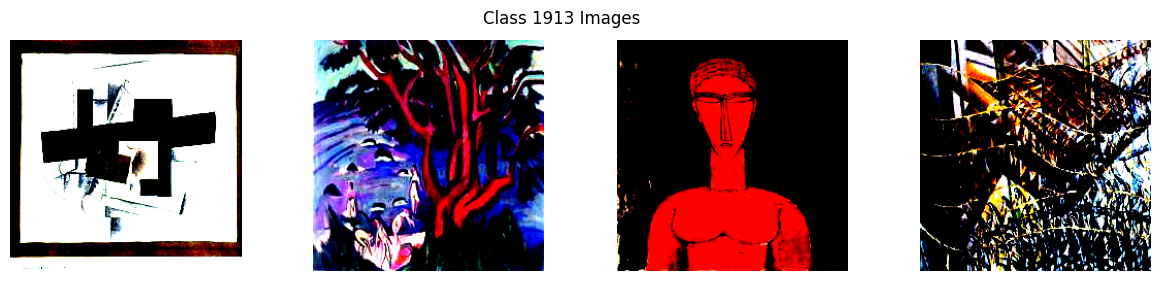

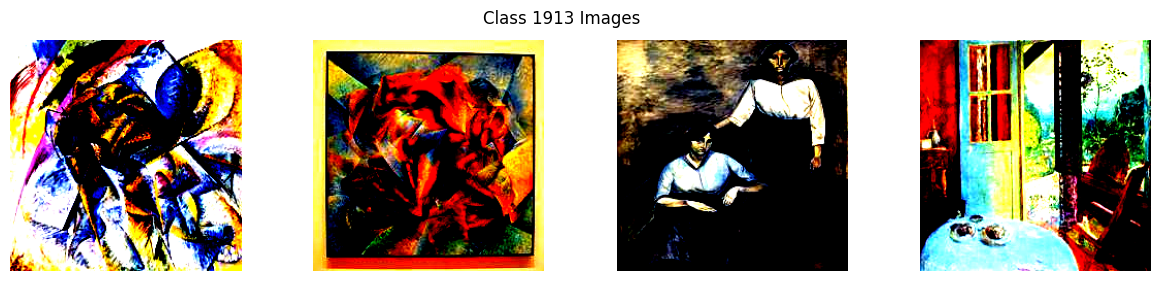

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, labels, class_name, num_images=4):
    # Find indices of images belonging to the specified class
    class_indices = [idx for idx, label in enumerate(labels) if label == class_name]
    # Randomly select 4 indices
    selected_indices = np.random.choice(class_indices, num_images, replace=False)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(f"Class {class_name} Images")
    for i, idx in enumerate(selected_indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for visualization
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Example: Show 4 images of class 0 from the training set
show_images(train_dataset, train_labels_tensor, class_name=1913)

# Example: Show 4 images of class 1 from the testing set
show_images(test_dataset, test_labels_tensor, class_name=1913)


In [9]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator



# NETWORK

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        # Ajustar el tamaño de la salida esperado por fc1 basado en el tamaño real de la salida después de la capa de dropout
        self.fc1 = nn.Linear(64 * 110 * 110, 128)  # Ajuste aquí

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x



#TRAIN AND TEST

In [11]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0.0  # Inicializa la pérdida acumulada en la época

    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Acumula la pérdida del lote en la pérdida de la época

    epoch_loss /= len(train_loader)  # Calcula el promedio de la pérdida de la época
    print("Epoch {}: Average Loss = {}".format(epoch, epoch_loss))  # Imprime la pérdida promedio de la época

    return epoch_loss  # Devuelve la pérdida promedio de la época

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator, loss_func,):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    return accuracies["precision_at_1"]


In [12]:
#!pip uninstall faiss-gpu
#!pip uninstall faiss-cpu
!pip install faiss-gpu
#!pip install faiss-cpu

In [29]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_metric_learning import miners, losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.distances import CosineSimilarity, LpDistance
from pytorch_metric_learning.reducers import ThresholdReducer
import matplotlib.pyplot as plt
import faiss

## TRAINING

Epoch 1: Average Loss = 0.3635360263288021


100%|██████████| 4/4 [00:00<00:00,  7.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.21
Epoch 2: Average Loss = 0.330226119607687


100%|██████████| 4/4 [00:00<00:00,  7.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.22
Epoch 3: Average Loss = 0.3216678872704506


100%|██████████| 4/4 [00:00<00:00, 10.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.21
Epoch 4: Average Loss = 0.31889233365654945


100%|██████████| 4/4 [00:00<00:00, 10.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24
Epoch 5: Average Loss = 0.3164927065372467


100%|██████████| 4/4 [00:00<00:00, 10.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.19
Epoch 6: Average Loss = 0.3151910603046417


100%|██████████| 4/4 [00:00<00:00,  8.06it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.19
Epoch 7: Average Loss = 0.31216447800397873


100%|██████████| 4/4 [00:00<00:00,  8.84it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2
Epoch 8: Average Loss = 0.31140658259391785


100%|██████████| 4/4 [00:00<00:00, 10.55it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2
Epoch 9: Average Loss = 0.31027865037322044


100%|██████████| 4/4 [00:00<00:00, 10.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.25
Epoch 10: Average Loss = 0.3094572611153126


100%|██████████| 4/4 [00:00<00:00, 10.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.25
[0.3635360263288021, 0.330226119607687, 0.3216678872704506, 0.31889233365654945, 0.3164927065372467, 0.3151910603046417, 0.31216447800397873, 0.31140658259391785, 0.31027865037322044, 0.3094572611153126]
[0.21, 0.22, 0.21, 0.24, 0.19, 0.19, 0.2, 0.2, 0.25, 0.25]


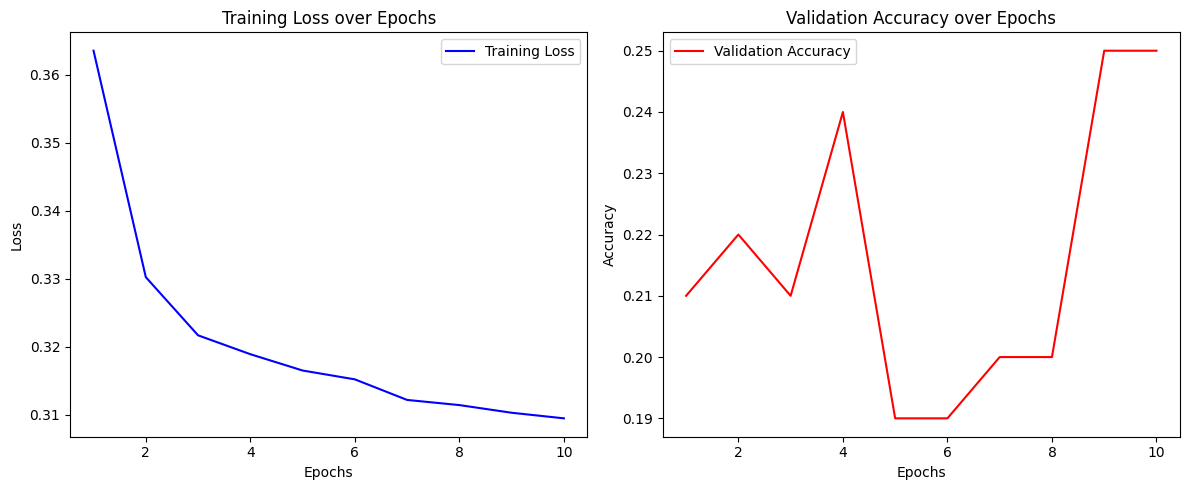

In [31]:
def plot_metrics(loss_history, accuracy_history):
    epochs = range(1, len(loss_history) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, 'b-', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, 'r-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
num_epochs = 10

# Pytorch-metric-learning configurations
distance = LpDistance()
reducer = ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.3, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="hard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=2)

losses_over_epochs = []
acc_over_epochs=[]
# Training and testing
for epoch in range(1, num_epochs + 1):
    epoch_loss = train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    losses_over_epochs.append(epoch_loss)
    acc=test(train_dataset, test_dataset, model, accuracy_calculator, loss_func)
    acc_over_epochs.append(acc)
print(losses_over_epochs)
print(acc_over_epochs)
plot_metrics(losses_over_epochs,acc_over_epochs)

In [19]:
import torch
import torch.optim as optim
from torchvision import models
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Carrega el model preentrenat ResNet50
model = models.resnet50(pretrained=True)

# Ajusta la capa final per al nombre correcte de classes
# Suposem que tens 10 classes, ajusta segons sigui necessari
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)  # Canvia 10 pel nombre de classes que necessitis

# Dispositiu de càlcul
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimitzador
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 30

# Configuracions de pytorch-metric-learning
distance = CosineSimilarity()
reducer = ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.1, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="hard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=2)

losses_over_epochs = []
acc_over_epochs = []

# Entrenament i test
for epoch in range(1, num_epochs + 1):
    epoch_loss = train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    losses_over_epochs.append(epoch_loss)
    acc = test(train_dataset, test_dataset, model, accuracy_calculator, loss_func)
    acc_over_epochs.append(acc)

print(losses_over_epochs)
print(acc_over_epochs)
plot_metrics(losses_over_epochs, acc_over_epochs)


Epoch 1: Average Loss = 0.1417526239529252


100%|██████████| 4/4 [00:00<00:00,  7.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24
Epoch 2: Average Loss = 0.1000381838530302


100%|██████████| 4/4 [00:00<00:00,  7.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.23
Epoch 3: Average Loss = 0.10001652128994465


100%|██████████| 4/4 [00:00<00:00,  8.50it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.24
Epoch 4: Average Loss = 0.10001073777675629


100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.2
Epoch 5: Average Loss = 0.10000657383352518


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.16
Epoch 6: Average Loss = 0.10000408068299294


100%|██████████| 4/4 [00:00<00:00,  8.11it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.16
Epoch 7: Average Loss = 0.10000305436551571


100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.28


KeyboardInterrupt: 